# Unsupervised Learning Using K-Means Clustering on California Housing Data

In this assignment, we will work with the California Housing dataset (we explored during Chapter 2 Labs) to explore unsupervised learning techniques using K-Means clustering. The task is to apply K-Means clustering, evaluate the results, and perform a comparative analysis with different cluster configurations. We will also analyze how the clustering results can be used to segment housing data for further insights.

In this notebook, we will:

1. Apply K-Means Clustering on the California Housing Dataset based on longitude, latitude and median_income
2. Optimize the Number of Clusters Using Silhouette Score: Calculate the silhouette score for different cluster configurations to evaluate the quality of clustering.
3. Analyze the Clustering Results
4. Visualize the clusters using scatter plots and compare the results for different values of k.
5. Discuss the distribution of data points in each cluster and their corresponding housing features (e.g., median income).
6. Interpret the results and explain how the clusters represent different segments of the housing market.
7. Comparison with Other Clustering Algorithms (Optional)
8. Optionally, compare K-Means with another clustering algorithm, such as DBSCAN, and discuss which performs better.

# Download the Data

In [1]:
# Download the data 
import os
import tarfile
import urllib.request
import warnings  # Import the warnings module

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


# Definition of how to fetch the data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)

    # Suppress the DeprecationWarning for tarfile extraction
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path, filter=None)
        housing_tgz.close()

In [2]:
# Execute fetching
fetch_housing_data()

In [3]:
import pandas as pd

# Definition of how to Load the housing csv from the path
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
import numpy as np

# to make this notebook's output identical at every run
np.random.seed(42)

In [5]:
# Create the housing data frame
housing = load_housing_data()

In [23]:
# Select relevant features: longitude, latitude, and median_income
housing_data_selected = housing[["longitude", "latitude", "median_income"]]

# Create K-Means in a Pipeline and a Scaller with silhouette_score 

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the number of clusters you want to explore
k_values = range(2, 100)

# Lists to store silhouette scores for each k
silhouette_scores = []

for k in k_values:
    # Create a pipeline with scaling and KMeans
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])
    
    # Fit the pipeline to the data
    pipeline.fit(housing_data_selected)
    
    # Predict cluster labels
    cluster_labels = pipeline.predict(housing_data_selected)
    
    # Calculate silhouette score
    score = silhouette_score(housing_data_selected, cluster_labels)
    silhouette_scores.append(score)


# Analyze the Clustering Results

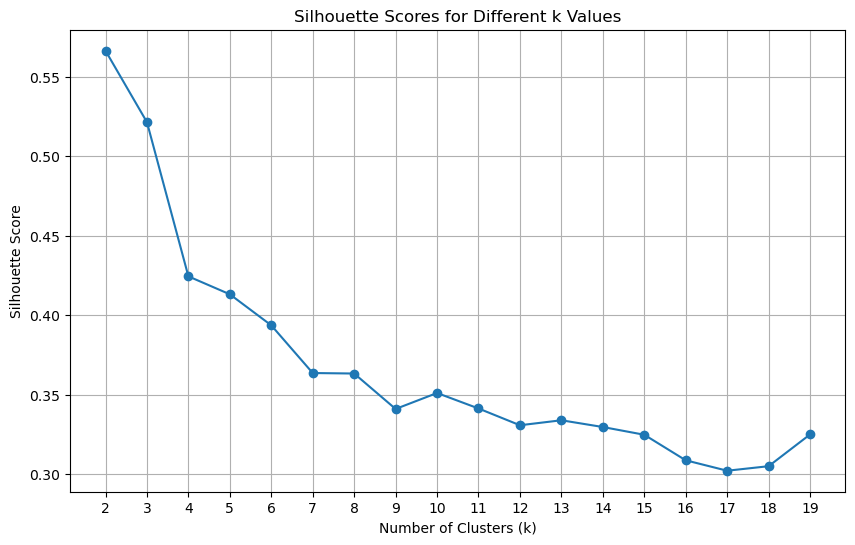

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = k_values[k - 1].labels_
    silhouette_coefficients = silhouette_samples(housing_data_selected, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

#save_fig("silhouette_analysis_plot")
plt.show()

## Step 4: Choose Optimal k and Visualize Clusters

In [ ]:
# Define the optimal number of clusters
optimal_k = 5

# Create a pipeline with scaling and KMeans
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=optimal_k, random_state=42))
])

# Fit the pipeline to the data
final_pipeline.fit(housing_data_selected)

# Predict cluster labels
housing['cluster'] = final_pipeline.predict(housing_data_selected)

# Visualize the clusters
plt.figure(figsize=(10, 7))
plt.scatter(
    housing['longitude'], 
    housing['latitude'], 
    c=housing['cluster'], 
    cmap='viridis', 
    marker='o', 
    edgecolor='k', 
    s=50,
    alpha=0.6
)
plt.title(f"K-Means Clustering with k={optimal_k} on California Housing Dataset")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Cluster')
plt.show()


### Extra ------------------------------------------

In [7]:
# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
housing_data_selected['Cluster'] = kmeans.fit_predict(housing_data_selected)

C:\Users\marco\AppData\Local\Temp\ipykernel_17412\2966237071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_data_selected['Cluster'] = kmeans.fit_predict(housing_data_selected)


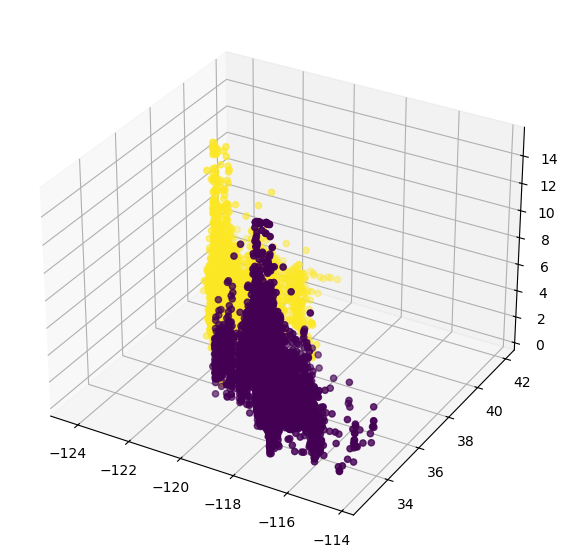

In [8]:
# Visualize clusters in 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(housing_data_selected['Longitude'], housing_data_selected['Latitude'], 
                     housing_data_selected['MedInc'], c=housing_data_selected['Cluster'], cmap='viridis')

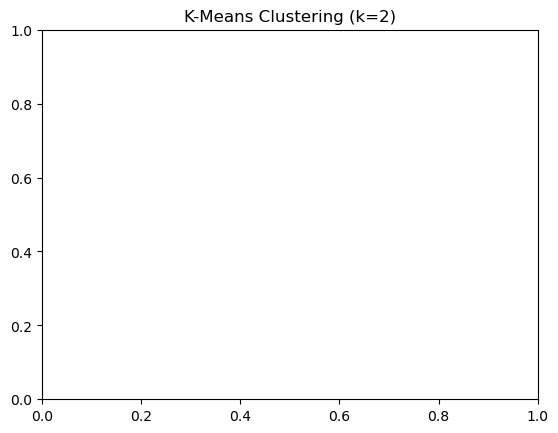

In [9]:
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Median Income')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.colorbar(scatter)
plt.show()

In [10]:
# Analyze and interpret clustering results
for cluster in range(optimal_k):
    cluster_data = housing_data_selected[housing_data_selected['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Number of data points: {len(cluster_data)}")
    print(f"Median income range: {cluster_data['MedInc'].min()} to {cluster_data['MedInc'].max()}")



Cluster 0:
Number of data points: 11943
Median income range: 0.4999 to 15.0001

Cluster 1:
Number of data points: 8697
Median income range: 0.4999 to 15.0001
